In [1]:
!pip install ultralytics opencv-python scikit-learn --quiet

from ultralytics import YOLO
import os
import shutil
import json
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


PyTorch version: 2.5.1+cu121
CUDA available: True
GPU name: Quadro RTX 4000


In [3]:
dataset_dir = r"C:\Users\navlog\Dataset_5"
images_dir = os.path.join(dataset_dir, "images")
labels_dir = os.path.join(dataset_dir, "labels")
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

coco_path = os.path.join(dataset_dir, "_annotations.coco.json")
with open(coco_path, 'r') as f:
    coco = json.load(f)

categories = {cat['id']: cat['name'] for cat in coco['categories']}
category_map = {cat_id: i for i, cat_id in enumerate(categories.keys())}

image_id_to_filename = {img['id']: img['file_name'] for img in coco['images']}
annotations_by_image = {}
for ann in coco['annotations']:
    image_id = ann['image_id']
    if image_id not in annotations_by_image:
        annotations_by_image[image_id] = []
    annotations_by_image[image_id].append(ann)

for image_id, anns in tqdm(annotations_by_image.items()):
    file_name = image_id_to_filename[image_id]
    txt_filename = os.path.splitext(file_name)[0] + ".txt"
    txt_path = os.path.join(labels_dir, txt_filename)
    with open(txt_path, 'w') as f:
        for ann in anns:
            cat_id = ann['category_id']
            bbox = ann['bbox']
            segmentation = ann.get("segmentation", [])
            if not segmentation or not isinstance(segmentation[0], list):
                continue
            poly = segmentation[0]
            norm_poly = [str(round(p / 1280 if i % 2 == 0 else p / 720, 6)) for i, p in enumerate(poly)]
            f.write(f"{category_map[cat_id]} " + " ".join(norm_poly) + "\n")

for img in coco['images']:
    src = os.path.join(dataset_dir, img['file_name'])
    dst = os.path.join(images_dir, img['file_name'])
    if os.path.exists(src) and not os.path.exists(dst):
        shutil.move(src, dst)


100%|██████████| 3467/3467 [00:05<00:00, 592.08it/s]


In [4]:
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

for split, file_list in [('train', train_files), ('val', val_files)]:
    for subdir in ['images', 'labels']:
        os.makedirs(os.path.join(dataset_dir, split, subdir), exist_ok=True)
    for img_file in file_list:
        base = os.path.splitext(img_file)[0]
        img_src = os.path.join(images_dir, img_file)
        label_src = os.path.join(labels_dir, base + '.txt')
        shutil.copy(img_src, os.path.join(dataset_dir, split, 'images', img_file))
        if os.path.exists(label_src):
            shutil.copy(label_src, os.path.join(dataset_dir, split, 'labels', base + '.txt'))


In [5]:
import os

# Example: dataset directory path
dataset_dir = r"C:\Users\navlog\Dataset_5"
data_yaml_path = os.path.join(dataset_dir, "data.yaml")

# Assuming categories is a dictionary like: {0: 'crack', 1: 'pore', 2: 'flash'}
class_names = list(categories.values())

# Precompute paths and replace backslashes with forward slashes
train_path = os.path.join(dataset_dir, 'train/images').replace('\\', '/')
val_path = os.path.join(dataset_dir, 'val/images').replace('\\', '/')

# Write the YAML content
with open(data_yaml_path, 'w') as f:
    f.write(f"train: {train_path}\n")
    f.write(f"val: {val_path}\n")
    f.write(f"nc: {len(class_names)}\n")
    f.write("names: [" + ", ".join(f"'{name}'" for name in class_names) + "]\n")


In [11]:
model = YOLO('yolov8n-seg.pt')
results = model.train(data=data_yaml_path, epochs=100, imgsz=640, batch=16, device=0)


New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.155  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (Quadro RTX 4000, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\navlog\Dataset_5\data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=seg_train_optimized, nbs=64, nms=False, 

train: Scanning C:\Users\navlog\Dataset_5\train\labels.cache... 2773 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2773/2773 [00:00<?, ?it/s]

WARNING cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (1.8GB RAM): 100%|██████████| 2773/2773 [00:00<00:00, 2829.05it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 21.55.1 MB/s, size: 12.9 KB)


val: Scanning C:\Users\navlog\Dataset_5\val\labels.cache... 694 images, 0 backgrounds, 0 corrupt: 100%|██████████| 694/694 [00:00<?, ?it/s]

WARNING cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.4GB RAM): 100%|██████████| 694/694 [00:00<00:00, 2564.40it/s]


Plotting labels to runs\segment\seg_train_optimized\labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\segment\seg_train_optimized
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.65G      2.816      5.347      5.085      2.608         28        640: 100%|██████████| 174/174 [00:42<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.06it/s]

                   all        694       1665    0.00101      0.194     0.0412     0.0151    0.00099      0.189     0.0331    0.00753



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.77G      2.187      4.404       3.36      2.037         25        640: 100%|██████████| 174/174 [00:39<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.02it/s]


                   all        694       1665      0.983      0.186      0.187     0.0943       0.98      0.184      0.184     0.0718

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.77G      1.976      3.843      2.365      1.708         18        640: 100%|██████████| 174/174 [00:39<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.00it/s]

                   all        694       1665      0.996      0.192      0.195      0.141      0.994      0.191      0.192      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.77G      1.817      3.604      2.013      1.525         14        640: 100%|██████████| 174/174 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.14it/s]

                   all        694       1665      0.997      0.195        0.2      0.152      0.996      0.196      0.198      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.77G      1.681      3.434      1.742      1.409         24        640: 100%|██████████| 174/174 [00:38<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.09it/s]


                   all        694       1665      0.997      0.195      0.205      0.154      0.997      0.194      0.198      0.137

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.77G      1.589      3.288      1.597      1.349         25        640: 100%|██████████| 174/174 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.10it/s]


                   all        694       1665      0.997      0.198       0.21      0.163      0.996      0.197      0.203      0.151

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.77G      1.514      3.158       1.51      1.306         31        640: 100%|██████████| 174/174 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.04it/s]

                   all        694       1665      0.609      0.227      0.211      0.164      0.593      0.209      0.204      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.77G      1.474      3.096      1.463      1.282         12        640: 100%|██████████| 174/174 [00:39<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]

                   all        694       1665      0.623      0.222      0.223      0.161      0.614      0.211      0.212      0.154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.77G      1.418      3.011      1.414      1.257         16        640: 100%|██████████| 174/174 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]


                   all        694       1665      0.679      0.256       0.25      0.175      0.646      0.234      0.228       0.16

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.77G      1.424      3.005      1.389      1.253         14        640: 100%|██████████| 174/174 [00:40<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.05it/s]


                   all        694       1665      0.687      0.255      0.254      0.172      0.674      0.227       0.23       0.16

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.77G      1.376      2.938      1.327      1.225         18        640: 100%|██████████| 174/174 [00:39<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.98it/s]


                   all        694       1665      0.668      0.258      0.257      0.184      0.655      0.245      0.241       0.17

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.77G       1.36      2.914      1.305      1.215         32        640: 100%|██████████| 174/174 [00:39<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.93it/s]

                   all        694       1665      0.732      0.253      0.269      0.191      0.707      0.237      0.243      0.172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.77G      1.339      2.879      1.301      1.206         32        640: 100%|██████████| 174/174 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]

                   all        694       1665      0.687      0.262       0.26      0.197       0.89      0.248      0.246       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.77G      1.316      2.814      1.271      1.195         32        640: 100%|██████████| 174/174 [00:39<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]

                   all        694       1665      0.724      0.271      0.277      0.197      0.675      0.254      0.251      0.169



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.77G      1.315      2.796      1.255      1.187         27        640: 100%|██████████| 174/174 [00:40<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.10it/s]


                   all        694       1665      0.894      0.252      0.262      0.182      0.845      0.221      0.209       0.15

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.77G      1.313      2.827       1.24      1.188         21        640: 100%|██████████| 174/174 [00:39<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.18it/s]

                   all        694       1665       0.93      0.264      0.279      0.205      0.929      0.254      0.266      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.77G      1.272      2.743      1.196      1.166         20        640: 100%|██████████| 174/174 [00:38<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.14it/s]

                   all        694       1665      0.698      0.289      0.286      0.203      0.915      0.257      0.264      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.77G      1.262       2.73      1.203      1.166         16        640: 100%|██████████| 174/174 [00:38<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.06it/s]

                   all        694       1665      0.891       0.26      0.276      0.206      0.709      0.257      0.261      0.181



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.77G      1.241      2.678      1.165      1.158         19        640: 100%|██████████| 174/174 [00:39<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]

                   all        694       1665      0.928      0.255      0.272      0.204       0.93      0.255      0.265      0.186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.77G      1.264      2.714      1.176      1.158         18        640: 100%|██████████| 174/174 [00:39<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]

                   all        694       1665      0.719      0.261      0.267      0.204      0.711      0.251      0.255      0.184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.77G      1.234      2.667      1.164      1.144         23        640: 100%|██████████| 174/174 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.04it/s]

                   all        694       1665        0.7      0.273      0.276      0.204      0.719      0.251       0.26      0.184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.77G      1.234      2.694      1.161      1.155         30        640: 100%|██████████| 174/174 [00:39<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]

                   all        694       1665      0.714      0.298      0.283      0.212      0.695      0.274      0.267      0.188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.77G      1.199      2.626      1.132      1.133         16        640: 100%|██████████| 174/174 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.06it/s]

                   all        694       1665       0.96      0.264      0.292      0.212      0.957       0.26      0.272      0.187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.77G       1.23      2.653      1.138      1.148         37        640: 100%|██████████| 174/174 [00:38<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.08it/s]

                   all        694       1665      0.794      0.293      0.289      0.205      0.744      0.278      0.267      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.77G      1.229       2.66      1.139      1.145         18        640: 100%|██████████| 174/174 [00:38<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.11it/s]

                   all        694       1665      0.704      0.284      0.278      0.216      0.696      0.279       0.27      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.77G       1.21      2.618      1.116      1.132         30        640: 100%|██████████| 174/174 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.29it/s]

                   all        694       1665      0.716      0.284       0.28      0.214       0.97      0.251      0.271      0.195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.77G      1.207      2.606      1.108       1.13         30        640: 100%|██████████| 174/174 [00:38<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.26it/s]

                   all        694       1665      0.721      0.293      0.289      0.212      0.712      0.272      0.276      0.187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.77G      1.186      2.557      1.095      1.127         19        640: 100%|██████████| 174/174 [00:38<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.17it/s]

                   all        694       1665      0.727      0.292      0.289       0.21      0.971      0.257      0.271      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.77G      1.187      2.578      1.091      1.125         31        640: 100%|██████████| 174/174 [00:37<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.23it/s]

                   all        694       1665      0.769      0.279      0.289      0.208      0.755      0.274      0.272      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.77G      1.184      2.591      1.089      1.129         22        640: 100%|██████████| 174/174 [00:38<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.26it/s]

                   all        694       1665      0.735      0.288      0.288      0.211       0.72       0.27      0.275      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.77G      1.173      2.558      1.081       1.12         14        640: 100%|██████████| 174/174 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]

                   all        694       1665       0.76      0.299      0.303      0.208      0.727      0.269      0.276      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.77G       1.18      2.543       1.08       1.12         22        640: 100%|██████████| 174/174 [00:38<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]

                   all        694       1665      0.728      0.289      0.291      0.219      0.733      0.277      0.273      0.195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.77G      1.164       2.49      1.052      1.113         28        640: 100%|██████████| 174/174 [00:37<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.08it/s]

                   all        694       1665      0.755      0.296        0.3      0.217      0.735      0.283      0.283      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.77G      1.163       2.52      1.058       1.11         16        640: 100%|██████████| 174/174 [00:37<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]

                   all        694       1665      0.763      0.293      0.299      0.217       0.72      0.273      0.271      0.193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.77G      1.163      2.509      1.057      1.114         24        640: 100%|██████████| 174/174 [00:38<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.08it/s]

                   all        694       1665      0.771      0.297      0.301      0.217      0.921      0.271      0.282      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.77G      1.163      2.508      1.047      1.113         26        640: 100%|██████████| 174/174 [00:37<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.17it/s]

                   all        694       1665      0.719      0.292      0.287      0.216      0.962      0.255      0.274      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.77G       1.15      2.479      1.041      1.111         25        640: 100%|██████████| 174/174 [00:38<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.20it/s]

                   all        694       1665      0.761      0.309      0.312      0.213      0.974      0.263      0.288      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.77G      1.148      2.488      1.033      1.106         26        640: 100%|██████████| 174/174 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]

                   all        694       1665      0.761      0.299      0.303      0.216      0.752      0.279      0.281      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.77G       1.15      2.492      1.023      1.101         19        640: 100%|██████████| 174/174 [00:38<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]

                   all        694       1665      0.721      0.295      0.293      0.223      0.964      0.258      0.276      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.77G      1.148      2.506      1.043      1.105         18        640: 100%|██████████| 174/174 [00:38<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.24it/s]

                   all        694       1665      0.768      0.294      0.298       0.22      0.745      0.279      0.278      0.195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.77G       1.14      2.462      1.026      1.095         36        640: 100%|██████████| 174/174 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]

                   all        694       1665      0.746      0.283      0.289      0.219      0.742       0.28       0.28      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.77G      1.133       2.47      1.015      1.103         25        640: 100%|██████████| 174/174 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.23it/s]

                   all        694       1665      0.744      0.302      0.297      0.217      0.733      0.284      0.282      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.77G      1.132       2.48      1.018      1.097         18        640: 100%|██████████| 174/174 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.17it/s]

                   all        694       1665      0.749      0.298      0.304      0.224      0.764      0.272      0.282      0.206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.77G      1.135      2.454      1.006      1.091         28        640: 100%|██████████| 174/174 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.13it/s]

                   all        694       1665      0.733      0.302        0.3      0.232      0.749      0.299      0.294      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.77G      1.134      2.446       1.01      1.097         23        640: 100%|██████████| 174/174 [00:37<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.20it/s]

                   all        694       1665      0.745      0.282      0.294      0.225      0.727      0.273      0.284      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.77G      1.116      2.428     0.9994      1.092         31        640: 100%|██████████| 174/174 [00:38<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.25it/s]

                   all        694       1665      0.797      0.299      0.309      0.222      0.741      0.279      0.275      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.77G      1.134      2.451       1.01      1.094         18        640: 100%|██████████| 174/174 [00:38<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.93it/s]

                   all        694       1665      0.746        0.3      0.304      0.225      0.757      0.293      0.291      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.77G      1.116      2.404     0.9849      1.085         28        640: 100%|██████████| 174/174 [00:38<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.24it/s]

                   all        694       1665      0.784      0.309      0.311      0.225      0.784      0.292      0.296      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.77G      1.136      2.444      1.014      1.092         24        640: 100%|██████████| 174/174 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]

                   all        694       1665      0.773      0.299      0.305      0.226      0.779      0.291      0.293      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.77G      1.118      2.427     0.9943      1.089         24        640: 100%|██████████| 174/174 [00:38<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.11it/s]

                   all        694       1665      0.746      0.315      0.311      0.225      0.741      0.289      0.291      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.77G      1.103      2.396     0.9888      1.086         23        640: 100%|██████████| 174/174 [00:39<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]

                   all        694       1665      0.795      0.314      0.321      0.231       0.78      0.291      0.292      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.77G      1.114      2.422     0.9966      1.087         21        640: 100%|██████████| 174/174 [00:38<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.18it/s]

                   all        694       1665      0.761      0.311      0.308      0.228      0.745      0.298      0.294      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.77G      1.111      2.397     0.9788      1.087         22        640: 100%|██████████| 174/174 [00:37<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]

                   all        694       1665      0.794      0.305      0.315      0.227      0.737      0.298      0.296      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.77G      1.094      2.379     0.9698      1.074         11        640: 100%|██████████| 174/174 [00:37<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.18it/s]

                   all        694       1665      0.784      0.307      0.312       0.23      0.773      0.301      0.298      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.77G      1.089      2.362      0.955      1.074         30        640: 100%|██████████| 174/174 [00:37<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.14it/s]

                   all        694       1665      0.792      0.319      0.324      0.225      0.776      0.302        0.3      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.77G        1.1      2.368     0.9652      1.082         19        640: 100%|██████████| 174/174 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]

                   all        694       1665       0.77      0.308      0.315      0.238      0.762      0.303        0.3      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.77G      1.095      2.379     0.9604      1.073         26        640: 100%|██████████| 174/174 [00:38<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.14it/s]

                   all        694       1665      0.739      0.315      0.311      0.225      0.727      0.308      0.299      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.77G      1.092      2.366     0.9656      1.082         25        640: 100%|██████████| 174/174 [00:38<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]

                   all        694       1665      0.774      0.303      0.305       0.23      0.764      0.294      0.297      0.204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.77G      1.085      2.365     0.9499       1.08         29        640: 100%|██████████| 174/174 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]

                   all        694       1665      0.785      0.313       0.32      0.241      0.795      0.296      0.303      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.77G       1.09      2.378     0.9558       1.07         37        640: 100%|██████████| 174/174 [00:38<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.09it/s]

                   all        694       1665      0.784      0.316      0.318      0.233      0.776      0.295      0.294      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.77G      1.075       2.35     0.9483      1.068         25        640: 100%|██████████| 174/174 [00:38<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.14it/s]

                   all        694       1665       0.78      0.329      0.331      0.238      0.785      0.307      0.314      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.77G      1.092      2.336     0.9552      1.076         20        640: 100%|██████████| 174/174 [00:37<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.23it/s]

                   all        694       1665      0.793      0.313      0.319      0.236       0.76      0.306      0.302      0.215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.77G      1.078       2.31     0.9444      1.071         21        640: 100%|██████████| 174/174 [00:37<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.03it/s]

                   all        694       1665      0.786      0.323      0.327       0.24      0.762       0.31      0.304      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.77G       1.08      2.354     0.9485      1.073         16        640: 100%|██████████| 174/174 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.14it/s]

                   all        694       1665      0.798      0.316      0.327      0.238      0.771      0.297      0.301      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.77G      1.074      2.331     0.9417      1.073         12        640: 100%|██████████| 174/174 [00:38<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]

                   all        694       1665      0.789      0.314      0.322      0.234      0.777       0.29      0.296       0.21



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.77G      1.073      2.337     0.9392      1.069         30        640: 100%|██████████| 174/174 [00:37<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.05it/s]

                   all        694       1665      0.793      0.317      0.324      0.239      0.783        0.3      0.308      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.77G      1.078      2.345     0.9365      1.067         14        640: 100%|██████████| 174/174 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.94it/s]

                   all        694       1665      0.596      0.319      0.325      0.238      0.578      0.309      0.308      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.77G      1.064      2.296      0.926      1.066         22        640: 100%|██████████| 174/174 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]

                   all        694       1665      0.797      0.317      0.331      0.236      0.762      0.301      0.299      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.77G      1.071      2.326     0.9341      1.066         29        640: 100%|██████████| 174/174 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.99it/s]

                   all        694       1665      0.771      0.329      0.329      0.238      0.765      0.307      0.312       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.77G      1.075      2.309     0.9281      1.067         18        640: 100%|██████████| 174/174 [00:40<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.06it/s]

                   all        694       1665      0.799       0.32      0.326      0.233      0.778        0.3      0.304      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.77G      1.092      2.338     0.9463      1.076         19        640: 100%|██████████| 174/174 [00:39<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.08it/s]

                   all        694       1665      0.786      0.319      0.324      0.244      0.771        0.3      0.305      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.77G      1.064      2.296     0.9252      1.067         21        640: 100%|██████████| 174/174 [00:39<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.02it/s]

                   all        694       1665      0.818      0.326      0.338      0.248      0.774      0.312      0.312      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.77G      1.069      2.295      0.928      1.069         15        640: 100%|██████████| 174/174 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.85it/s]

                   all        694       1665      0.809      0.324      0.329      0.232      0.777      0.311      0.309      0.204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.77G      1.063      2.294     0.9151      1.065         14        640: 100%|██████████| 174/174 [00:42<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.92it/s]

                   all        694       1665      0.777      0.325      0.322      0.238      0.778      0.311       0.31      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.77G      1.061      2.308     0.9208      1.066         31        640: 100%|██████████| 174/174 [00:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.00it/s]

                   all        694       1665      0.816      0.318       0.33      0.246      0.784      0.313       0.31      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.77G      1.054      2.281     0.9134      1.064         34        640: 100%|██████████| 174/174 [00:41<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.94it/s]

                   all        694       1665      0.797       0.33      0.335      0.249      0.776      0.318      0.314      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.77G      1.069       2.32     0.9246      1.065         29        640: 100%|██████████| 174/174 [00:42<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]

                   all        694       1665      0.818      0.313      0.328      0.241      0.792      0.304      0.312      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.77G      1.053      2.289     0.9125      1.054         31        640: 100%|██████████| 174/174 [00:42<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.92it/s]

                   all        694       1665      0.835      0.318      0.333      0.246      0.815      0.304      0.315      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.77G      1.057      2.275     0.9127      1.057         22        640: 100%|██████████| 174/174 [00:42<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.99it/s]

                   all        694       1665      0.805      0.326      0.333      0.238       0.77      0.308      0.308      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.77G      1.054      2.264      0.903      1.052         19        640: 100%|██████████| 174/174 [00:42<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.92it/s]

                   all        694       1665       0.82      0.324      0.335      0.251      0.777      0.316      0.318      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.77G      1.047      2.257     0.9071      1.058         16        640: 100%|██████████| 174/174 [00:43<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.79it/s]

                   all        694       1665      0.782      0.325      0.329      0.244      0.781      0.311      0.312      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.77G      1.026      2.236     0.8853      1.049         25        640: 100%|██████████| 174/174 [00:43<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.86it/s]

                   all        694       1665      0.617      0.322      0.335      0.242      0.602      0.317      0.318      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.77G      1.056       2.27     0.9034      1.057         11        640: 100%|██████████| 174/174 [00:42<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.95it/s]

                   all        694       1665      0.796      0.325      0.331      0.242      0.798      0.311      0.315      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.77G       1.04      2.266      0.894      1.049         31        640: 100%|██████████| 174/174 [00:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.86it/s]

                   all        694       1665      0.803      0.323      0.334      0.248      0.798      0.319      0.319      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.77G      1.049      2.276     0.9084      1.057         16        640: 100%|██████████| 174/174 [00:42<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.97it/s]

                   all        694       1665      0.782      0.337      0.337      0.249      0.783      0.318      0.318      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.77G      1.035      2.248     0.8895      1.049         20        640: 100%|██████████| 174/174 [00:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.82it/s]

                   all        694       1665      0.787      0.332      0.334      0.248       0.77      0.321      0.321      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.77G      1.036      2.245     0.8905      1.053         24        640: 100%|██████████| 174/174 [00:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.94it/s]

                   all        694       1665      0.785      0.325      0.331      0.232      0.789      0.315      0.315      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.77G      1.063      2.288      0.922      1.063         11        640: 100%|██████████| 174/174 [00:40<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.03it/s]

                   all        694       1665      0.792      0.326      0.334      0.244       0.78      0.314      0.317       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.77G      1.036      2.247      0.889      1.049         19        640: 100%|██████████| 174/174 [00:40<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.86it/s]

                   all        694       1665       0.81      0.329      0.335      0.247      0.796      0.318       0.32      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.77G      1.039       2.25      0.893      1.053         27        640: 100%|██████████| 174/174 [00:40<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]

                   all        694       1665        0.8      0.331      0.335      0.247      0.777      0.316      0.317      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.77G      1.027      2.255     0.8871      1.048         15        640: 100%|██████████| 174/174 [00:41<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.84it/s]

                   all        694       1665       0.84      0.321      0.339      0.251       0.82      0.313      0.321      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.77G      1.022      2.226     0.8825      1.043         29        640: 100%|██████████| 174/174 [00:41<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.88it/s]

                   all        694       1665      0.802      0.335       0.34      0.247      0.789      0.326      0.324      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.77G      1.029      2.204     0.8722      1.048         22        640: 100%|██████████| 174/174 [00:40<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]

                   all        694       1665      0.819      0.335      0.344      0.253       0.82      0.323      0.328      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.77G      1.029      2.219      0.881      1.043         25        640: 100%|██████████| 174/174 [00:41<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.91it/s]

                   all        694       1665      0.796      0.333      0.337      0.251      0.792      0.318       0.32      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.77G      1.028      2.225     0.8864      1.046         23        640: 100%|██████████| 174/174 [00:40<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.08it/s]

                   all        694       1665      0.803      0.337      0.342       0.25       0.78       0.32      0.319      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.77G      1.023      2.215     0.8762      1.042         21        640: 100%|██████████| 174/174 [00:40<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]

                   all        694       1665      0.793      0.332       0.34      0.254       0.78       0.32      0.323      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.77G      1.023      2.215     0.8734      1.046         21        640: 100%|██████████| 174/174 [00:39<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.88it/s]

                   all        694       1665      0.792      0.342      0.342      0.252      0.779      0.332      0.327      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.77G      1.033      2.236     0.8871      1.049         22        640: 100%|██████████| 174/174 [00:39<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.03it/s]

                   all        694       1665      0.792      0.341      0.341      0.249      0.776      0.325      0.321      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.77G      1.033       2.22     0.8785      1.046         15        640: 100%|██████████| 174/174 [00:39<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.20it/s]

                   all        694       1665      0.796       0.34      0.342      0.246      0.781      0.332      0.327      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.77G      1.019      2.198     0.8686       1.04         18        640: 100%|██████████| 174/174 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.11it/s]

                   all        694       1665      0.762      0.343       0.34       0.25      0.762      0.326      0.324      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.77G      1.021      2.213     0.8731      1.042         33        640: 100%|██████████| 174/174 [00:38<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.04it/s]

                   all        694       1665      0.785      0.343      0.342      0.252      0.772       0.33      0.323      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.77G      1.027      2.226     0.8814      1.049         17        640: 100%|██████████| 174/174 [00:39<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.11it/s]

                   all        694       1665      0.799      0.342      0.345      0.252      0.788      0.332       0.33      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.77G      1.025      2.211     0.8754      1.042         17        640: 100%|██████████| 174/174 [00:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.90it/s]

                   all        694       1665      0.777      0.341      0.339      0.251      0.768      0.324       0.32      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.77G      1.028      2.229     0.8849       1.05         33        640: 100%|██████████| 174/174 [00:42<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.09it/s]

                   all        694       1665      0.793      0.344       0.34      0.251      0.784       0.33      0.326      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.77G      1.018      2.212     0.8759      1.043         18        640: 100%|██████████| 174/174 [00:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.99it/s]

                   all        694       1665      0.789      0.343       0.34      0.253      0.779      0.328      0.322      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.77G      1.029      2.213     0.8796      1.046         17        640: 100%|██████████| 174/174 [00:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.05it/s]

                   all        694       1665      0.775      0.342      0.338      0.249      0.775      0.325      0.323      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.77G      1.011      2.207     0.8683      1.037         19        640: 100%|██████████| 174/174 [00:40<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.08it/s]

                   all        694       1665      0.791      0.345      0.341      0.253      0.777      0.325      0.325      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.77G      1.005      2.175      0.861      1.035         14        640: 100%|██████████| 174/174 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.17it/s]

                   all        694       1665      0.806      0.343      0.344      0.248      0.787      0.331       0.33      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.77G      1.019      2.183     0.8748       1.04         24        640: 100%|██████████| 174/174 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]

                   all        694       1665      0.802      0.342      0.346      0.255      0.783      0.327      0.328       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.77G      1.005      2.195     0.8622      1.034         18        640: 100%|██████████| 174/174 [00:38<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]

                   all        694       1665      0.812      0.345      0.348      0.252      0.781      0.334      0.328      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.77G      1.015      2.187     0.8582      1.039         19        640: 100%|██████████| 174/174 [00:39<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.05it/s]

                   all        694       1665      0.603      0.342      0.344      0.256      0.594      0.339      0.334      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.77G      1.001      2.184     0.8601       1.04         35        640: 100%|██████████| 174/174 [00:39<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.04it/s]

                   all        694       1665      0.799      0.343      0.342      0.253      0.793      0.333       0.33      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.77G       1.01      2.189     0.8707      1.037         18        640: 100%|██████████| 174/174 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]

                   all        694       1665      0.797      0.343      0.341      0.252       0.79      0.333      0.329      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.77G      1.005      2.181     0.8533      1.034         17        640: 100%|██████████| 174/174 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]

                   all        694       1665      0.804      0.343      0.344      0.254      0.786      0.327      0.326       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.77G      1.014      2.181     0.8665       1.04         11        640: 100%|██████████| 174/174 [00:38<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.14it/s]

                   all        694       1665      0.796      0.345      0.341      0.251      0.785      0.333      0.329      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.77G       1.01      2.176     0.8553      1.034         27        640: 100%|██████████| 174/174 [00:38<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.11it/s]

                   all        694       1665      0.787      0.344      0.343      0.255      0.781      0.326      0.328      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.77G      1.007      2.198     0.8653      1.042         18        640: 100%|██████████| 174/174 [00:39<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.11it/s]

                   all        694       1665      0.796      0.346      0.343       0.25       0.78      0.334      0.328      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.77G     0.9923      2.156     0.8481      1.033         11        640: 100%|██████████| 174/174 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.99it/s]

                   all        694       1665      0.796      0.342      0.342      0.256       0.78      0.326      0.324      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.77G      1.008      2.176     0.8616      1.036         16        640: 100%|██████████| 174/174 [00:39<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.03it/s]

                   all        694       1665      0.798      0.341       0.34      0.254      0.792      0.331      0.328      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.77G      1.002      2.189     0.8566      1.036         16        640: 100%|██████████| 174/174 [00:39<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.09it/s]

                   all        694       1665      0.776      0.348      0.342      0.249      0.769      0.338      0.327      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.77G      1.001      2.151     0.8496      1.031         20        640: 100%|██████████| 174/174 [00:39<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]

                   all        694       1665      0.798       0.34      0.343      0.253      0.784      0.331      0.325      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.77G      1.015      2.175     0.8621      1.045         20        640: 100%|██████████| 174/174 [00:39<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]

                   all        694       1665      0.791      0.339      0.341      0.255      0.785      0.336      0.331      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.77G     0.9873      2.151      0.841      1.029         30        640: 100%|██████████| 174/174 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.82it/s]

                   all        694       1665      0.794      0.346      0.347      0.256        0.8      0.336      0.334      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.77G      1.002      2.146     0.8484      1.034         25        640: 100%|██████████| 174/174 [00:37<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]

                   all        694       1665      0.799      0.344      0.347      0.255      0.786      0.336      0.331      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.77G     0.9963      2.168     0.8473      1.033         22        640: 100%|██████████| 174/174 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.15it/s]

                   all        694       1665      0.795      0.348      0.344      0.251      0.797      0.338      0.335      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.77G     0.9971      2.165     0.8546      1.032         15        640: 100%|██████████| 174/174 [00:38<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.08it/s]

                   all        694       1665      0.811      0.349      0.349      0.256      0.805      0.335      0.332       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.77G      1.003      2.161      0.853      1.035         15        640: 100%|██████████| 174/174 [00:39<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.02it/s]

                   all        694       1665      0.803      0.348      0.349      0.255      0.805       0.34      0.335      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.77G     0.9968       2.17     0.8471      1.031         27        640: 100%|██████████| 174/174 [00:39<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.13it/s]

                   all        694       1665      0.815      0.345      0.351      0.258      0.809      0.336      0.335      0.233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.77G     0.9979      2.158     0.8407      1.031         18        640: 100%|██████████| 174/174 [00:39<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.02it/s]

                   all        694       1665      0.795      0.349      0.346      0.254      0.798      0.336      0.332      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.77G      0.983       2.14     0.8409      1.027         16        640: 100%|██████████| 174/174 [00:38<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.96it/s]

                   all        694       1665      0.802      0.347      0.349      0.256      0.799       0.34      0.334       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.77G     0.9906       2.13      0.845      1.029         33        640: 100%|██████████| 174/174 [00:38<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]

                   all        694       1665      0.802      0.344      0.347      0.255      0.802      0.339      0.335      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.77G     0.9911      2.147     0.8434      1.026         13        640: 100%|██████████| 174/174 [00:38<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.14it/s]

                   all        694       1665      0.803      0.347       0.35      0.257      0.804      0.335      0.336      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.77G     0.9892      2.154     0.8426      1.028         21        640: 100%|██████████| 174/174 [00:38<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.13it/s]

                   all        694       1665      0.805       0.35       0.35      0.258      0.806      0.336      0.333      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.77G     0.9905      2.131     0.8392      1.033         24        640: 100%|██████████| 174/174 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.95it/s]

                   all        694       1665      0.798      0.349      0.347      0.255      0.789      0.337      0.331      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.77G     0.9886      2.138     0.8445      1.032         18        640: 100%|██████████| 174/174 [00:39<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.13it/s]

                   all        694       1665      0.805      0.348      0.348      0.261      0.794      0.339      0.335      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.77G     0.9852      2.129     0.8434      1.026         20        640: 100%|██████████| 174/174 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.92it/s]

                   all        694       1665      0.802       0.35      0.349       0.26      0.801      0.341      0.336      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.77G     0.9775      2.121     0.8394      1.027         15        640: 100%|██████████| 174/174 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.20it/s]

                   all        694       1665      0.803      0.348      0.349      0.258      0.801       0.34      0.335      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.77G     0.9806      2.083     0.8308      1.028         12        640: 100%|██████████| 174/174 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.21it/s]

                   all        694       1665        0.8      0.351      0.348      0.257      0.795      0.343      0.334      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.77G     0.9773      2.116     0.8345      1.025         19        640: 100%|██████████| 174/174 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]

                   all        694       1665      0.798      0.346      0.345      0.256      0.799      0.341      0.332      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.77G     0.9866      2.158     0.8471      1.031         32        640: 100%|██████████| 174/174 [00:39<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.05it/s]

                   all        694       1665      0.803      0.348      0.349      0.258      0.799       0.34      0.335      0.233


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.77G      1.037      2.233     0.9794       1.07         13        640: 100%|██████████| 174/174 [00:41<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.09it/s]

                   all        694       1665      0.613      0.346      0.349      0.254      0.594      0.335       0.33      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.77G     0.9931       2.16     0.9374      1.056         10        640: 100%|██████████| 174/174 [00:39<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.13it/s]

                   all        694       1665      0.801      0.345      0.348      0.256       0.79      0.335      0.332      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.77G     0.9722      2.166     0.9305      1.049         13        640: 100%|██████████| 174/174 [00:39<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.27it/s]

                   all        694       1665        0.6      0.345      0.348      0.256      0.585      0.334      0.331      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.77G     0.9747      2.134     0.9305       1.05         10        640: 100%|██████████| 174/174 [00:40<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.09it/s]

                   all        694       1665      0.596      0.347      0.344      0.257      0.584      0.339      0.334      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.77G     0.9697      2.124     0.9204      1.048         11        640: 100%|██████████| 174/174 [00:39<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.21it/s]

                   all        694       1665        0.6      0.348      0.351      0.258      0.596      0.341      0.336       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.77G     0.9617      2.107     0.9209      1.047          9        640: 100%|██████████| 174/174 [00:39<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]

                   all        694       1665      0.607      0.351      0.353       0.26      0.592      0.339      0.336      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.77G      0.966      2.122     0.9274      1.045         12        640: 100%|██████████| 174/174 [00:38<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]

                   all        694       1665      0.606      0.347      0.348      0.258      0.623       0.34      0.338      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.77G     0.9699      2.118     0.9218      1.047          5        640: 100%|██████████| 174/174 [00:38<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.95it/s]

                   all        694       1665      0.603      0.348      0.347      0.258      0.606      0.338      0.336       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.77G     0.9674      2.118     0.9164      1.047         13        640: 100%|██████████| 174/174 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.10it/s]

                   all        694       1665       0.61      0.348      0.348      0.258      0.604       0.34      0.338      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.77G     0.9592      2.091      0.912      1.045         12        640: 100%|██████████| 174/174 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]

                   all        694       1665      0.607      0.347      0.348      0.259      0.607       0.34      0.339      0.232



150 epochs completed in 1.987 hours.
Optimizer stripped from runs\segment\seg_train_optimized\weights\last.pt, 6.8MB
Optimizer stripped from runs\segment\seg_train_optimized\weights\best.pt, 6.8MB

Validating runs\segment\seg_train_optimized\weights\best.pt...
Ultralytics 8.3.155  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (Quadro RTX 4000, 8192MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,259,624 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/22 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   5%|▍         | 1/22 [00:00<00:10,  2.05it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 2/22 [00:01<00:13,  1.47it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.63it/s]


                   all        694       1665      0.805      0.348      0.348      0.261      0.796      0.338      0.335      0.235
                  Burs        480        913      0.281      0.136      0.105     0.0337      0.246      0.102     0.0837     0.0194
                 Flash        124        132      0.757      0.606       0.64      0.355      0.742      0.591      0.598      0.231
              Key Hole          2          2          1          0          0          0          1          0          0          0
                  Weld        614        614       0.99      0.998      0.995      0.914       0.99      0.998      0.995      0.927
                  void          4          4          1          0          0          0          1          0          0          0
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\segment\seg_train_optimized



0: 640x640 1 Weld, 16.1ms
Speed: 9.7ms preprocess, 16.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Frame 0 - Mask 0 - Class: Weld, Width: 10.53 mm

0: 640x640 (no detections), 13.6ms
Speed: 3.0ms preprocess, 13.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 28.2ms
Speed: 6.3ms preprocess, 28.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 5.7ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.9ms
Speed: 3.7ms preprocess, 17.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 23.9ms
Speed: 6.5ms preprocess, 23.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1

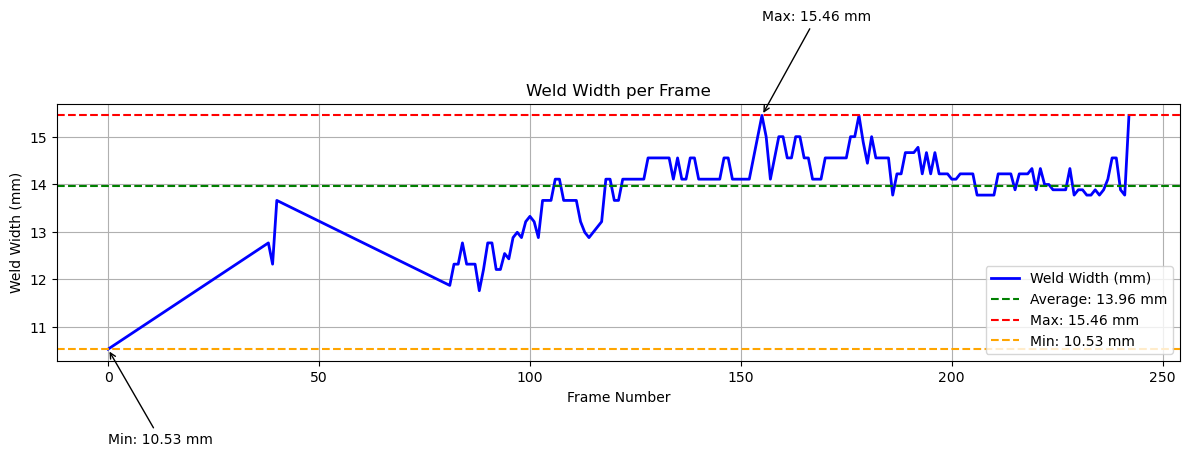

[INFO] Weld width plot saved to: C:\Users\navlog\Dataset_5\videos and width measurement\weld_width_plot_5.png


In [15]:
import cv2
import numpy as np
from datetime import datetime
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd  # Added for saving CSV
from ultralytics import YOLO

# --- Configurable paths ---
video_path = r"C:\Users\navlog\Dataset_5\videos and width measurement\Video_5.mp4"
model_path = "runs/segment/train/weights/best.pt"
output_video_path = r"C:\Users\navlog\Dataset_5\videos and width measurement\segmented_output_refined_colored_5.mp4"
output_frames_dir = r"C:\Users\navlog\Dataset_5\videos and width measurement\output_frames_refined_colored_5"
csv_filename = r"C:\Users\navlog\Dataset_5\videos and width measurement\weld_widths_5.csv"
plot_filename = r"C:\Users\navlog\Dataset_5\videos and width measurement\weld_width_plot_5.png"

# --- Check input files ---
assert os.path.isfile(video_path), f"File not found: {video_path}"
assert os.path.isfile(model_path), f"Model not found: {model_path}"

# --- Load model ---
model = YOLO(model_path)

# --- Initialize video capture ---
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"[ERROR] Failed to open video: {video_path}")
    exit()

# --- Target resolution (YOLOv8 trained size) ---
target_width, target_height = 640, 640
fps = cap.get(cv2.CAP_PROP_FPS)

# --- Initialize video writer ---
out = cv2.VideoWriter(
    output_video_path,
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (target_width, target_height)
)
os.makedirs(output_frames_dir, exist_ok=True)

# --- Color palette for drawing masks by class ---
color_palette = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255),
    (255, 255, 0), (255, 0, 255), (0, 255, 255),
    (128, 0, 128), (0, 128, 255)
]

# --- Scale: mm per pixel (based on camera setup) ---
scale_mm_per_pixel = 0.115  # Adjust if needed

# --- Weld class name (case-insensitive match) ---
weld_class_name = "weld"

# --- Function for letterboxing ---
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=False, scaleFill=False, scaleup=True):
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:
        r = min(r, 1.0)

    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]

    if auto:
        dw, dh = np.mod(dw, 32), np.mod(dh, 32)

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)

    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return img, ratio, (dw, dh)

# --- Tracking weld widths ---
weld_widths = []  # (frame_index, weld_width_mm)

# --- Processing loop ---
frame_index = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # --- Resize using letterbox ---
    frame_resized, ratio, (pad_w, pad_h) = letterbox(frame, (target_width, target_height), auto=False)
    mask_frame = frame_resized.copy()

    # --- Run YOLOv8 segmentation ---
    results = model(frame_resized, conf=0.5, iou=0.5)[0]

    if results.masks is not None:
        masks = results.masks.data.cpu().numpy()
        classes = results.boxes.cls.cpu().numpy().astype(int)

        for idx, (mask, cls_id) in enumerate(zip(masks, classes)):
            binary_mask = (mask > 0.5).astype(np.uint8) * 255

            # --- Refine mask ---
            kernel = np.ones((3, 3), np.uint8)
            refined = cv2.erode(binary_mask, kernel, iterations=1)
            refined = cv2.morphologyEx(refined, cv2.MORPH_OPEN, kernel)

            # --- Find contours ---
            contours, _ = cv2.findContours(refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            color = color_palette[cls_id % len(color_palette)]
            cv2.drawContours(mask_frame, contours, -1, color, 2)

            class_name = model.names[cls_id]

            if class_name.lower() == weld_class_name.lower():
                # --- Calculate and display width in mm ---
                max_width_pixels = 0
                max_rect = None
                for cnt in contours:
                    if cnt.size > 0:
                        x, y, w, h = cv2.boundingRect(cnt)
                        if w > max_width_pixels:
                            max_width_pixels = w
                            max_rect = (x, y, w, h)

                if max_rect is not None:
                    x, y, w, h = max_rect
                    width_mm = w * scale_mm_per_pixel
                    label = f"{class_name} width: {width_mm:.2f} mm"
                    cv2.putText(mask_frame, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                    print(f"Frame {frame_index} - Mask {idx} - Class: {class_name}, Width: {width_mm:.2f} mm")
                    weld_widths.append((frame_index, width_mm))
            else:
                # --- Only label other classes ---
                for cnt in contours:
                    if cnt.size > 0:
                        x, y, w, h = cv2.boundingRect(cnt)
                        label = f"{class_name}"
                        cv2.putText(mask_frame, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # --- Show and save output ---
    cv2.imshow("Refined Colored Segmentation", mask_frame)
    out.write(mask_frame)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S%f")
    cv2.imwrite(os.path.join(output_frames_dir, f"frame_{frame_index}_{timestamp}.jpg"), mask_frame)

    frame_index += 1
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# --- Cleanup ---
cap.release()
out.release()
cv2.destroyAllWindows()

# --- Save weld widths to CSV ---
if weld_widths:
    df = pd.DataFrame(weld_widths, columns=["Frame", "Weld_Width_mm"])
    df.to_csv(csv_filename, index=False)
    print(f"[INFO] Weld width data saved to: {csv_filename}")

    # --- Plot weld width over frames ---
    frames, widths = zip(*weld_widths)
    avg_width = np.mean(widths)
    max_width = np.max(widths)
    min_width = np.min(widths)

    plt.figure(figsize=(12, 6))
    plt.plot(frames, widths, label="Weld Width (mm)", color="blue", linewidth=2)
    plt.axhline(avg_width, color="green", linestyle="--", label=f"Average: {avg_width:.2f} mm")
    plt.axhline(max_width, color="red", linestyle="--", label=f"Max: {max_width:.2f} mm")
    plt.axhline(min_width, color="orange", linestyle="--", label=f"Min: {min_width:.2f} mm")

    # Annotate max and min
    max_idx = widths.index(max_width)
    min_idx = widths.index(min_width)
    plt.annotate(f"Max: {max_width:.2f} mm", xy=(frames[max_idx], max_width),
                 xytext=(frames[max_idx], max_width + 2), arrowprops=dict(arrowstyle="->"))
    plt.annotate(f"Min: {min_width:.2f} mm", xy=(frames[min_idx], min_width),
                 xytext=(frames[min_idx], min_width - 2), arrowprops=dict(arrowstyle="->"))

    plt.xlabel("Frame Number")
    plt.ylabel("Weld Width (mm)")
    plt.title("Weld Width per Frame")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(plot_filename)
    plt.show()
    print(f"[INFO] Weld width plot saved to: {plot_filename}")
else:
    print("[INFO] No weld width data to save or plot.")
